In [1]:
%matplotlib inline

In [2]:
# from KnackpackData import getEncoded,getScores,scoreFunction,n_items
# import matplotlib.pyplot as plt
# import numpy as np
# import random

from KnackpackData import getEncoded,getScores,scoreFunction,n_items,weights,values,max_weight,getDiff
from Timer import *
import matplotlib.pyplot as plt
import numpy as np
import random
t = Timer()

In [61]:
class SimulatedAnnealing:
    def __init__(self, initial_temp = 1000, alpha = 0.999, frozen_level = 0.1, n_items = 16, values = [], weights = [], max_weight = 3, iteration = 0):
        self.initial_temp = initial_temp
        self.alpha = alpha
        self.frozen_level = frozen_level
        self.n_items = n_items
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
        self.iter = iteration
        self.results = []
        
    def setInitialValues(self, initial_state = None):
        '''Wyzeruj tablice wyników oraz ustaw wartości początkowe.'''
        
        if initial_state is None:
            # Stan początkowy jest po prostu pustym plecakiem.
            self.initial_state = np.zeros(self.n_items).astype(bool)
        else:
            self.initial_state = initial_state
        self.best_state = self.initial_state
        self.current_state = self.initial_state
        
        self.temperature = self.initial_temp

        # Tablice wyników zawierają tylko zerowy stan.
        self.scores_table = [np.sum(self.values[self.initial_state])]
        self.best_scores_table = [np.sum(self.values[self.initial_state])]
        self.best_value_index = 0
    
    def run(self):
        if self.temperature is None:
            self.setInitialValues()
            
        it = 0
        while self.temperature > self.frozen_level:
            it += 1
            # Generate next state
            next_state = np.copy(self.current_state)
            idx = np.random.randint(0,self.n_items) # get random index to flip
            next_state[idx] = 1 - next_state[idx] # flip generated index

            self.scores_table.append(np.sum(self.values[next_state]))

            # Calculate delta (if next state is better than current)
            delta = np.sum(self.values[next_state]) - np.sum(self.values[self.current_state])

            if delta > 0 and np.sum(self.weights[next_state]) <= self.max_weight:
                # If next state is better than current - set this state as current
                self.current_state = np.copy(next_state)

                # If new state is better than the best - set this state as best
                if np.sum(self.values[self.current_state]) > np.sum(self.values[self.best_state]):
                    self.best_state = np.copy(self.current_state)
                    self.best_value_index = it
                    self.best_scores_table.append(np.sum(self.values[self.best_state]))
            else:
                # If the new solution is not better, accept it with a probability of e^(-delta/temp)
                acceptance_function = np.exp(-delta / self.temperature)
                if acceptance_function > random.uniform(0, 1):
                    self.current_state = np.copy(next_state)

            self.results.append(self.current_state)
            self.temperature *= self.alpha
#         print(it)
        
    def results(self):
        best_value = np.sum(self.values[self.best_state])
        best_weight = np.sum(self.weights[self.best_state])
        print("Best value: ",best_value)
        print("Best weight: ",best_weight)
        print("Difference (value, weight):", getDiff(n_items,best_value, best_weight))
        
    def plot_results(self, plot = 'best_of_all'):
        if plot == 'best_of_all':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.scatter(self.best_value_index, np.array(self.scores_table)[self.best_value_index], color="r", s=200, zorder=2)
            plt.plot(np.arange(np.array(self.scores_table).size), np.array(self.scores_table), color="b", zorder=1)
            plt.title('Value changes')
        elif plot == 'best_changes':
            plt.figure(figsize=(16, 12), dpi=80)
            plt.plot(np.arange(np.array(self.best_scores_table).size), np.array(self.best_scores_table), color="b")
            plt.title('Best results changes')
            
        plt.ylabel('Value')
        plt.xlabel('Iteration')
        plt.show()
    def getResults(self):
        return [np.sum(self.values[self.best_state]), np.sum(self.weights[self.best_state]), self.iter]
    
    def getStates(self):
        return self.results

## Initial population takes 20% of items

In [4]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.8*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

## Fitness score by value of backpack

In [5]:
def fitness_score(population):
    return np.array(list(map(scoreFunction, population)))

## Roulette wheel selection

In [6]:
def selection(scores,population_nextgen,k,population_size):
    return random.choices(population_nextgen, weights = scores, k=population_size)

## Single point crossover

In [7]:
def crossover(pop_after_sel,crossover_rate):
    def crossingMethod(index):
        point = random.randint(0, len(pop_after_sel[0]))
        next_index = (index+1)%len(pop_after_sel)
        return np.concatenate((pop_after_sel[index][:point],pop_after_sel[next_index][point:]))
    childrens = np.array([crossingMethod(index) for index in range(len(pop_after_sel)) if random.random() < crossover_rate])
    return np.concatenate((pop_after_sel,childrens))

## Bit flip mutation

In [8]:
def mutation(pop_after_cross,mutation_rate):
    def mutate(unit):
        i = random.randint(0, len(unit)-1)
        unit[i]=!unit[i]
        return unit
    return np.array([mutate(cross) if random.random() < mutation_rate else cross for cross in pop_after_cross ])

## Generation loop with stop conditions:

* no change of best score through *max_stale_iterations*

*  90% of the population fall within convergence of the fittest individual

In [60]:
from math import isclose
def generations(population_size,n_feat,crossover_rate,mutation_rate,k_tournament,max_iteration,max_stale_iterations):
    def pupulation_in_convergence(scores,iteration_best_score):
        return sum(isclose(iteration_best_score,score) for score in scores)/scores.size>0.9
    alltime_best_score = 0
    stale_iteration = 0
    stop_reason = "Reached max_iteration!"
    # fittest does not change
    best_chromo= []
    best_score= []
    results_annealing = []
    population_nextgen=initilization_of_population(population_size,n_feat)
    for i in range(max_iteration):
        print(i,end="\r")
        
#         population_nextgen = SA.
        scores = fitness_score(population_nextgen)
        bestIndex = np.argmax(scores)
        
        
        SA = SimulatedAnnealing(2500, 0.96, 0.1, 16, values, weights, max_weight, i)
        SA.setInitialValues(population_nextgen[bestIndex])
        SA.run()
        results_annealing.append(SA.getResults())
#         print(population_nextgen)
        population_nextgen = SA.getStates()
    
        scores = fitness_score(population_nextgen)
        bestIndex = np.argmax(scores)
        
        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        
        
        pop_after_sel = selection(scores,population_nextgen,k_tournament,population_size)
        pop_after_cross = crossover(pop_after_sel,crossover_rate)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        
        

        if alltime_best_score >= scores[bestIndex]:
            stale_iteration+=1
        else :
            stale_iteration=0
            alltime_best_score = scores[bestIndex]
        
        if stale_iteration>=max_stale_iterations:
            stop_reason = "Reached max_stale_iterations!"
            break
        if pupulation_in_convergence(scores,scores[bestIndex]):
            stop_reason = "Pupulation converge in 90%!"
            break
  
    return best_chromo,best_score,stop_reason,results_annealing

## Visualization methods

In [10]:
from operator import itemgetter
def plotScore(scores,bestindex):
    plt.figure(figsize=(8, 6), dpi=80) 
    plt.plot(scores)
    plt.scatter(bestindex, scores[bestindex],color="g",s=50)
    plt.annotate("best", (bestindex,scores[bestindex]))
    plt.ylabel('scores')
    plt.show()
    
def getBest(chromosomes,scores):
    best = max(zip(chromosomes,scores), key=itemgetter(1))
    bestindex = scores.index(best[1])
    return best,bestindex

In [ ]:
np.random.seed(seed=1337)
random.seed(1337)
chromo,score,stop_reason,=generations(population_size=100,n_feat=n_items,crossover_rate=0.1,mutation_rate=0.3,k_tournament=0,max_iteration=100,max_stale_iterations=30)
print(stop_reason)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x = best[0]
y = scoreFunction(best[0])
print(f"Final value{x}={y}")

## Wynik 
Nie jest maksimum globalnym

## K-Tournament Selection(20)

In [57]:
def selection(scores,population_nextgen,k,population_size):
    def tournament_selection(indices):
        return population_nextgen[max(indices,key=lambda index:scores[index])]
    return np.array([tournament_selection(random.choices(range(scores.size),k = k)) for _ in range(population_size)])

## Two point mutation?

In [58]:
def mutation(pop_after_cross,mutation_rate):
    def mutate(unit):
        i = random.randint(0, len(unit)-1)
        j = random.randint(0, len(unit)-1)
        unit[i]=!unit[i]
        unit[j]=!unit[j]
        return unit
    return np.array([mutate(cross) if random.random() < mutation_rate else cross for cross in pop_after_cross ])

## To use with SIMULATED ANNEALING ALGORITHM

Reached max_stale_iterations!


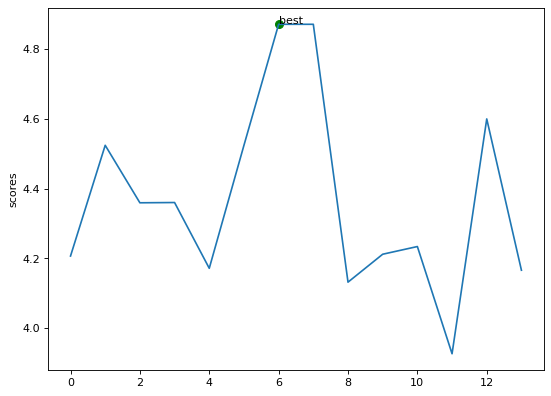

Final value[ True  True  True  True  True False  True False False  True False False
  True False False  True]=4.871708393096924


In [62]:
chromo,score,stop_reason,results_annealing=generations(population_size=100,n_feat=n_items,crossover_rate=0.8,mutation_rate=0.2,k_tournament=20,max_iteration=100,max_stale_iterations=7)
print(stop_reason)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x = best[0]
y = scoreFunction(best[0])
print(f"Final value{x}={y}")

In [63]:
len(results_annealing)

14

In [64]:
np.array(results_annealing)

array([[ 4.10653093,  2.94746797,  0.        ],
       [ 4.52458099,  2.98248509,  1.        ],
       [ 4.52458099,  2.98248509,  2.        ],
       [ 4.6485701 ,  2.98524307,  3.        ],
       [ 4.53897163,  2.83857437,  4.        ],
       [ 4.52458099,  2.98248509,  5.        ],
       [ 4.87170844,  2.77098602,  6.        ],
       [ 4.87170844,  2.77098602,  7.        ],
       [ 4.87170844,  2.77098602,  8.        ],
       [ 4.25539917,  2.91942575,  9.        ],
       [ 4.58057866,  2.61719164, 10.        ],
       [ 4.6085299 ,  2.92920945, 11.        ],
       [ 4.56815124,  2.84970205, 12.        ],
       [ 4.60023287,  2.95439409, 13.        ]])

In [35]:
results_annealing[results_annealing[:, 0].argsort()]


TypeError: list indices must be integers or slices, not tuple

## Wynik 
Wynik to maksimum globalne